In [1]:
import sys

sys.path.append('../gtm/')
sys.path.append('../simulation/')

In [2]:
import importlib
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import pickle
import numpy as np
from random import random
import torch
import pandas as pd
from tqdm import tqdm
from corpus import GTMCorpus
from patsy import dmatrix
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA

from corpus import GTMCorpus
from gtm import GTM
from sim_gtm import generate_docs_by_gtm, estimate_dist_by_gtm
from sim_lda import generate_docs_by_lda, estimate_dist_by_lda

/Users/shim-kojio/Desktop/internship/codes/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import importlib
import gtm
importlib.reload(gtm)
from gtm import GTM

### diri * sage (update=False)

In [4]:
doc_args = {
    "min_words": 50,
    "max_words": 100,
    "num_docs": 10000,
    "voc_size": 1000,
}
cossim_list = []
true_doc_topic_list = []
estimated_doc_topic_list = []
mean_train_loss_list = []
for num_topics in range(3,21):
    gtm_model_args = {
        "n_topics": num_topics,
        "num_epochs":10,
        "update_prior": False,
        "w_prior":None,
        "doc_topic_prior": "dirichlet",
        "decoder_type": "sage",
        "encoder_hidden_layers":[],
        "decoder_hidden_layers":[300],
        "decoder_bias":False,
        "batch_size":200,
        "print_every":10000,
        "log_every":1,
        "seed":0
        }
    df_true_dist_list_gtm, docs_gtm = generate_docs_by_gtm(
        num_topics=num_topics,
        doc_topic_prior=gtm_model_args["doc_topic_prior"],
        decoder_type=gtm_model_args["decoder_type"],
        seed=0,
        update_prior=gtm_model_args["update_prior"],
        doc_args=doc_args,
        is_output=False,
    )
    ### doc topic distribution (without covs)
    df_test = pd.DataFrame(
        data={
            "doc":docs_gtm["doc"],
            "doc_clean":docs_gtm["doc"]
        }
    )
    test_dataset = GTMCorpus(
        df_test,
        embeddings_type = None,
    )
    tm_test = GTM(
        train_data = test_dataset,
        **gtm_model_args
    )
    mean_train_loss_list.append(tm_test.mean_train_loss)
    df_doc_topic_gtm = pd.DataFrame(
            tm_test.get_doc_topic_distribution(test_dataset),
            index=["Doc{}".format(i) for i in range(doc_args["num_docs"])],
            columns=["Topic{}".format(i) for i in range(num_topics)],
        )
    true_df = df_true_dist_list_gtm[0]
    estimated_df = df_doc_topic_gtm

    ### matching the columns of estimated doc_topic dist with those of true doc_topic dist by maximizing dot-product
    score_list = []
    for true_col in true_df.columns:
        true_target_col = true_df.loc[:, true_col]
        score_list_per_row = []
        for col in estimated_df.columns:
            target_col = estimated_df.loc[:, col]
            score_list_per_row.append(np.dot(target_col, true_target_col))
        score_list.append(score_list_per_row)
    corres_num_topic_dict_gtm = {}
    score_matrix = pd.DataFrame(score_list)
    true_topics, estimated_topics = linear_sum_assignment(-score_matrix)
    for true_topic, estimated_topic in zip(true_topics, estimated_topics):
        corres_num_topic_dict_gtm["Topic{}".format(true_topic)] = "Topic{}".format(
            estimated_topic
        )
    reanged_df_gtm = estimated_df.loc[:, corres_num_topic_dict_gtm.values()]
    reanged_df_gtm.columns = corres_num_topic_dict_gtm.keys()

    true_doc_topic_list.append(true_df)
    estimated_doc_topic_list.append(reanged_df_gtm)

    ### calculating the cossim scores between true and estimated doc_topic dist
    cossim_score_gtm = []
    for col in true_df.columns:
        inner_res = []
        series_1 = true_df.loc[:, col]
        series_2 = reanged_df_gtm.loc[:, col]
        cossim_score_gtm.append(
            np.dot(series_1.T, series_2)
            / (np.linalg.norm(series_1) * np.linalg.norm(series_2)))
    cossim_list.append(cossim_score_gtm)
    print("finished {} topics' simulation".format(num_topics))
    print()

100%|██████████| 10000/10000 [01:57<00:00, 84.95it/s]



Epoch   1	Mean Training Loss:11.0437199

Topic_0: ['word_65', 'word_141', 'word_27', 'word_332', 'word_787']
Topic_1: ['word_337', 'word_693', 'word_650', 'word_182', 'word_69']
Topic_2: ['word_648', 'word_78', 'word_685', 'word_891', 'word_758']



Epoch   2	Mean Training Loss:6.3367955

Topic_0: ['word_65', 'word_27', 'word_141', 'word_332', 'word_787']
Topic_1: ['word_337', 'word_693', 'word_650', 'word_69', 'word_182']
Topic_2: ['word_648', 'word_891', 'word_78', 'word_685', 'word_266']



Epoch   3	Mean Training Loss:4.7803496

Topic_0: ['word_65', 'word_27', 'word_141', 'word_332', 'word_787']
Topic_1: ['word_337', 'word_693', 'word_650', 'word_69', 'word_182']
Topic_2: ['word_648', 'word_78', 'word_891', 'word_266', 'word_982']



Epoch   4	Mean Training Loss:4.4651630

Topic_0: ['word_65', 'word_27', 'word_141', 'word_787', 'word_8']
Topic_1: ['word_337', 'word_693', 'word_650', 'word_69', 'word_182']
Topic_2: ['word_78', 'word_266', 'word_648', 'word_982', 'word_799']



Epoc

100%|██████████| 10000/10000 [01:58<00:00, 84.37it/s]



Epoch   1	Mean Training Loss:12.3389570

Topic_0: ['word_319', 'word_748', 'word_757', 'word_908', 'word_850']
Topic_1: ['word_649', 'word_857', 'word_955', 'word_386', 'word_676']
Topic_2: ['word_672', 'word_871', 'word_623', 'word_925', 'word_312']
Topic_3: ['word_287', 'word_801', 'word_82', 'word_286', 'word_285']



Epoch   2	Mean Training Loss:9.2625365

Topic_0: ['word_319', 'word_757', 'word_748', 'word_850', 'word_181']
Topic_1: ['word_649', 'word_857', 'word_386', 'word_589', 'word_955']
Topic_2: ['word_672', 'word_871', 'word_623', 'word_312', 'word_421']
Topic_3: ['word_287', 'word_82', 'word_801', 'word_400', 'word_286']



Epoch   3	Mean Training Loss:6.9422064

Topic_0: ['word_850', 'word_757', 'word_181', 'word_319', 'word_877']
Topic_1: ['word_649', 'word_648', 'word_386', 'word_857', 'word_589']
Topic_2: ['word_871', 'word_672', 'word_312', 'word_623', 'word_212']
Topic_3: ['word_287', 'word_82', 'word_801', 'word_400', 'word_870']



Epoch   4	Mean Training Loss:6.2

100%|██████████| 10000/10000 [01:59<00:00, 83.77it/s]



Epoch   1	Mean Training Loss:11.3581312

Topic_0: ['word_705', 'word_150', 'word_777', 'word_221', 'word_441']
Topic_1: ['word_64', 'word_800', 'word_496', 'word_984', 'word_481']
Topic_2: ['word_177', 'word_976', 'word_438', 'word_741', 'word_311']
Topic_3: ['word_605', 'word_524', 'word_650', 'word_338', 'word_385']
Topic_4: ['word_805', 'word_859', 'word_377', 'word_38', 'word_89']



Epoch   2	Mean Training Loss:4.4320468

Topic_0: ['word_705', 'word_150', 'word_441', 'word_324', 'word_66']
Topic_1: ['word_64', 'word_800', 'word_496', 'word_984', 'word_28']
Topic_2: ['word_177', 'word_438', 'word_976', 'word_311', 'word_935']
Topic_3: ['word_605', 'word_58', 'word_524', 'word_650', 'word_961']
Topic_4: ['word_38', 'word_859', 'word_377', 'word_805', 'word_89']



Epoch   3	Mean Training Loss:3.6978553

Topic_0: ['word_705', 'word_253', 'word_150', 'word_78', 'word_221']
Topic_1: ['word_800', 'word_496', 'word_64', 'word_28', 'word_984']
Topic_2: ['word_177', 'word_438', 'word_741'

100%|██████████| 10000/10000 [02:00<00:00, 82.72it/s]



Epoch   1	Mean Training Loss:13.2616811

Topic_0: ['word_420', 'word_230', 'word_862', 'word_126', 'word_81']
Topic_1: ['word_582', 'word_474', 'word_4', 'word_347', 'word_843']
Topic_2: ['word_785', 'word_533', 'word_148', 'word_415', 'word_837']
Topic_3: ['word_789', 'word_267', 'word_484', 'word_596', 'word_706']
Topic_4: ['word_715', 'word_230', 'word_440', 'word_337', 'word_512']
Topic_5: ['word_182', 'word_279', 'word_594', 'word_602', 'word_370']



Epoch   2	Mean Training Loss:11.0392125

Topic_0: ['word_230', 'word_862', 'word_420', 'word_81', 'word_159']
Topic_1: ['word_474', 'word_582', 'word_347', 'word_68', 'word_843']
Topic_2: ['word_785', 'word_533', 'word_415', 'word_148', 'word_837']
Topic_3: ['word_789', 'word_267', 'word_596', 'word_484', 'word_686']
Topic_4: ['word_715', 'word_230', 'word_440', 'word_337', 'word_374']
Topic_5: ['word_182', 'word_279', 'word_594', 'word_314', 'word_302']



Epoch   3	Mean Training Loss:7.7304084

Topic_0: ['word_230', 'word_126', 'w

100%|██████████| 10000/10000 [01:57<00:00, 84.82it/s]



Epoch   1	Mean Training Loss:13.5110701

Topic_0: ['word_896', 'word_81', 'word_754', 'word_606', 'word_999']
Topic_1: ['word_708', 'word_124', 'word_946', 'word_625', 'word_58']
Topic_2: ['word_342', 'word_346', 'word_92', 'word_235', 'word_862']
Topic_3: ['word_384', 'word_38', 'word_558', 'word_806', 'word_274']
Topic_4: ['word_396', 'word_676', 'word_153', 'word_291', 'word_296']
Topic_5: ['word_499', 'word_401', 'word_923', 'word_970', 'word_872']
Topic_6: ['word_844', 'word_960', 'word_781', 'word_1', 'word_184']



Epoch   2	Mean Training Loss:10.8783220

Topic_0: ['word_896', 'word_606', 'word_754', 'word_81', 'word_658']
Topic_1: ['word_708', 'word_124', 'word_153', 'word_891', 'word_625']
Topic_2: ['word_342', 'word_235', 'word_346', 'word_92', 'word_137']
Topic_3: ['word_384', 'word_38', 'word_274', 'word_483', 'word_806']
Topic_4: ['word_396', 'word_676', 'word_153', 'word_54', 'word_291']
Topic_5: ['word_499', 'word_497', 'word_970', 'word_923', 'word_401']
Topic_6: ['wor

100%|██████████| 10000/10000 [01:58<00:00, 84.61it/s]



Epoch   1	Mean Training Loss:13.3083018

Topic_0: ['word_283', 'word_276', 'word_605', 'word_300', 'word_609']
Topic_1: ['word_870', 'word_811', 'word_833', 'word_372', 'word_663']
Topic_2: ['word_683', 'word_79', 'word_2', 'word_491', 'word_642']
Topic_3: ['word_519', 'word_582', 'word_727', 'word_43', 'word_624']
Topic_4: ['word_550', 'word_749', 'word_283', 'word_896', 'word_388']
Topic_5: ['word_235', 'word_390', 'word_725', 'word_154', 'word_808']
Topic_6: ['word_201', 'word_910', 'word_109', 'word_985', 'word_937']
Topic_7: ['word_783', 'word_57', 'word_244', 'word_446', 'word_2']



Epoch   2	Mean Training Loss:9.6691252

Topic_0: ['word_276', 'word_144', 'word_283', 'word_609', 'word_300']
Topic_1: ['word_811', 'word_870', 'word_663', 'word_833', 'word_372']
Topic_2: ['word_683', 'word_491', 'word_79', 'word_2', 'word_15']
Topic_3: ['word_582', 'word_519', 'word_274', 'word_190', 'word_86']
Topic_4: ['word_550', 'word_749', 'word_896', 'word_388', 'word_826']
Topic_5: ['word_2

100%|██████████| 10000/10000 [01:57<00:00, 85.12it/s]



Epoch   1	Mean Training Loss:13.6483583

Topic_0: ['word_451', 'word_583', 'word_577', 'word_921', 'word_889']
Topic_1: ['word_787', 'word_241', 'word_150', 'word_661', 'word_834']
Topic_2: ['word_372', 'word_50', 'word_720', 'word_772', 'word_449']
Topic_3: ['word_599', 'word_703', 'word_84', 'word_658', 'word_803']
Topic_4: ['word_40', 'word_12', 'word_209', 'word_645', 'word_162']
Topic_5: ['word_255', 'word_713', 'word_762', 'word_347', 'word_116']
Topic_6: ['word_999', 'word_684', 'word_694', 'word_961', 'word_118']
Topic_7: ['word_451', 'word_629', 'word_829', 'word_548', 'word_945']
Topic_8: ['word_631', 'word_925', 'word_728', 'word_830', 'word_618']



Epoch   2	Mean Training Loss:10.1552209

Topic_0: ['word_889', 'word_583', 'word_577', 'word_921', 'word_451']
Topic_1: ['word_787', 'word_661', 'word_150', 'word_757', 'word_834']
Topic_2: ['word_449', 'word_50', 'word_772', 'word_720', 'word_924']
Topic_3: ['word_599', 'word_84', 'word_803', 'word_107', 'word_358']
Topic_4: [

100%|██████████| 10000/10000 [01:58<00:00, 84.60it/s]



Epoch   1	Mean Training Loss:13.4815884

Topic_0: ['word_569', 'word_458', 'word_438', 'word_108', 'word_856']
Topic_1: ['word_444', 'word_511', 'word_603', 'word_735', 'word_562']
Topic_2: ['word_386', 'word_659', 'word_82', 'word_323', 'word_950']
Topic_3: ['word_287', 'word_614', 'word_826', 'word_905', 'word_933']
Topic_4: ['word_405', 'word_525', 'word_668', 'word_88', 'word_326']
Topic_5: ['word_151', 'word_420', 'word_37', 'word_95', 'word_775']
Topic_6: ['word_84', 'word_19', 'word_627', 'word_725', 'word_513']
Topic_7: ['word_325', 'word_254', 'word_669', 'word_304', 'word_486']
Topic_8: ['word_28', 'word_575', 'word_819', 'word_983', 'word_180']
Topic_9: ['word_762', 'word_752', 'word_101', 'word_687', 'word_230']



Epoch   2	Mean Training Loss:9.7095780

Topic_0: ['word_458', 'word_636', 'word_856', 'word_438', 'word_569']
Topic_1: ['word_511', 'word_603', 'word_444', 'word_530', 'word_735']
Topic_2: ['word_386', 'word_659', 'word_950', 'word_719', 'word_627']
Topic_3: ['w

100%|██████████| 10000/10000 [01:58<00:00, 84.39it/s]



Epoch   1	Mean Training Loss:13.6168172

Topic_0: ['word_225', 'word_355', 'word_776', 'word_598', 'word_909']
Topic_1: ['word_531', 'word_371', 'word_476', 'word_896', 'word_535']
Topic_2: ['word_278', 'word_498', 'word_838', 'word_330', 'word_533']
Topic_3: ['word_188', 'word_438', 'word_404', 'word_138', 'word_790']
Topic_4: ['word_343', 'word_672', 'word_392', 'word_223', 'word_413']
Topic_5: ['word_988', 'word_478', 'word_220', 'word_15', 'word_181']
Topic_6: ['word_580', 'word_790', 'word_726', 'word_861', 'word_959']
Topic_7: ['word_45', 'word_693', 'word_462', 'word_755', 'word_91']
Topic_8: ['word_822', 'word_740', 'word_222', 'word_352', 'word_954']
Topic_9: ['word_595', 'word_433', 'word_825', 'word_678', 'word_538']
Topic_10: ['word_92', 'word_533', 'word_480', 'word_737', 'word_309']



Epoch   2	Mean Training Loss:9.8302006

Topic_0: ['word_355', 'word_909', 'word_598', 'word_225', 'word_776']
Topic_1: ['word_531', 'word_371', 'word_702', 'word_476', 'word_535']
Topic_2:

100%|██████████| 10000/10000 [01:58<00:00, 84.64it/s]



Epoch   1	Mean Training Loss:13.2398998

Topic_0: ['word_548', 'word_628', 'word_505', 'word_587', 'word_920']
Topic_1: ['word_620', 'word_771', 'word_201', 'word_690', 'word_95']
Topic_2: ['word_188', 'word_160', 'word_686', 'word_852', 'word_96']
Topic_3: ['word_248', 'word_811', 'word_914', 'word_709', 'word_129']
Topic_4: ['word_508', 'word_330', 'word_700', 'word_138', 'word_283']
Topic_5: ['word_334', 'word_625', 'word_288', 'word_273', 'word_977']
Topic_6: ['word_465', 'word_818', 'word_85', 'word_811', 'word_813']
Topic_7: ['word_104', 'word_869', 'word_972', 'word_979', 'word_420']
Topic_8: ['word_96', 'word_345', 'word_203', 'word_79', 'word_840']
Topic_9: ['word_838', 'word_290', 'word_137', 'word_910', 'word_890']
Topic_10: ['word_611', 'word_549', 'word_940', 'word_506', 'word_999']
Topic_11: ['word_493', 'word_370', 'word_378', 'word_598', 'word_546']



Epoch   2	Mean Training Loss:9.5557101

Topic_0: ['word_548', 'word_628', 'word_189', 'word_505', 'word_920']
Topic_1:

100%|██████████| 10000/10000 [01:58<00:00, 84.24it/s]



Epoch   1	Mean Training Loss:13.6043684

Topic_0: ['word_298', 'word_393', 'word_445', 'word_894', 'word_619']
Topic_1: ['word_444', 'word_962', 'word_326', 'word_963', 'word_545']
Topic_2: ['word_208', 'word_394', 'word_595', 'word_605', 'word_909']
Topic_3: ['word_247', 'word_720', 'word_491', 'word_124', 'word_303']
Topic_4: ['word_905', 'word_78', 'word_974', 'word_853', 'word_967']
Topic_5: ['word_864', 'word_268', 'word_773', 'word_559', 'word_871']
Topic_6: ['word_226', 'word_167', 'word_510', 'word_190', 'word_156']
Topic_7: ['word_460', 'word_846', 'word_251', 'word_257', 'word_2']
Topic_8: ['word_823', 'word_126', 'word_522', 'word_280', 'word_279']
Topic_9: ['word_669', 'word_210', 'word_50', 'word_81', 'word_1']
Topic_10: ['word_265', 'word_338', 'word_766', 'word_45', 'word_381']
Topic_11: ['word_806', 'word_239', 'word_11', 'word_162', 'word_910']
Topic_12: ['word_646', 'word_760', 'word_502', 'word_86', 'word_768']



Epoch   2	Mean Training Loss:9.8261728

Topic_0: ['w

100%|██████████| 10000/10000 [01:57<00:00, 84.79it/s]



Epoch   1	Mean Training Loss:13.7721960

Topic_0: ['word_562', 'word_32', 'word_411', 'word_741', 'word_356']
Topic_1: ['word_776', 'word_305', 'word_999', 'word_7', 'word_296']
Topic_2: ['word_873', 'word_355', 'word_89', 'word_745', 'word_646']
Topic_3: ['word_734', 'word_417', 'word_308', 'word_253', 'word_645']
Topic_4: ['word_356', 'word_495', 'word_608', 'word_65', 'word_661']
Topic_5: ['word_449', 'word_611', 'word_603', 'word_437', 'word_461']
Topic_6: ['word_181', 'word_428', 'word_772', 'word_240', 'word_963']
Topic_7: ['word_209', 'word_94', 'word_578', 'word_524', 'word_2']
Topic_8: ['word_372', 'word_965', 'word_751', 'word_674', 'word_707']
Topic_9: ['word_119', 'word_202', 'word_117', 'word_949', 'word_398']
Topic_10: ['word_354', 'word_486', 'word_165', 'word_218', 'word_137']
Topic_11: ['word_330', 'word_666', 'word_464', 'word_818', 'word_152']
Topic_12: ['word_840', 'word_649', 'word_789', 'word_176', 'word_159']
Topic_13: ['word_135', 'word_718', 'word_530', 'word_

100%|██████████| 10000/10000 [01:57<00:00, 84.92it/s]



Epoch   1	Mean Training Loss:13.7672659

Topic_0: ['word_569', 'word_278', 'word_808', 'word_683', 'word_231']
Topic_1: ['word_761', 'word_150', 'word_956', 'word_711', 'word_246']
Topic_2: ['word_136', 'word_442', 'word_607', 'word_34', 'word_635']
Topic_3: ['word_670', 'word_983', 'word_737', 'word_867', 'word_300']
Topic_4: ['word_40', 'word_559', 'word_646', 'word_730', 'word_488']
Topic_5: ['word_568', 'word_954', 'word_509', 'word_110', 'word_678']
Topic_6: ['word_997', 'word_88', 'word_406', 'word_134', 'word_494']
Topic_7: ['word_279', 'word_648', 'word_493', 'word_869', 'word_21']
Topic_8: ['word_235', 'word_115', 'word_641', 'word_354', 'word_388']
Topic_9: ['word_883', 'word_489', 'word_551', 'word_517', 'word_939']
Topic_10: ['word_845', 'word_365', 'word_125', 'word_326', 'word_253']
Topic_11: ['word_606', 'word_71', 'word_221', 'word_215', 'word_106']
Topic_12: ['word_515', 'word_634', 'word_489', 'word_311', 'word_178']
Topic_13: ['word_621', 'word_599', 'word_640', 'wo

100%|██████████| 10000/10000 [01:58<00:00, 84.44it/s]



Epoch   1	Mean Training Loss:13.6708514

Topic_0: ['word_846', 'word_953', 'word_506', 'word_152', 'word_789']
Topic_1: ['word_999', 'word_852', 'word_16', 'word_428', 'word_321']
Topic_2: ['word_701', 'word_744', 'word_956', 'word_628', 'word_421']
Topic_3: ['word_167', 'word_282', 'word_478', 'word_955', 'word_482']
Topic_4: ['word_551', 'word_433', 'word_233', 'word_256', 'word_707']
Topic_5: ['word_966', 'word_531', 'word_597', 'word_903', 'word_762']
Topic_6: ['word_21', 'word_412', 'word_115', 'word_996', 'word_431']
Topic_7: ['word_450', 'word_330', 'word_170', 'word_542', 'word_314']
Topic_8: ['word_391', 'word_663', 'word_563', 'word_11', 'word_215']
Topic_9: ['word_467', 'word_316', 'word_918', 'word_158', 'word_190']
Topic_10: ['word_504', 'word_635', 'word_999', 'word_975', 'word_65']
Topic_11: ['word_528', 'word_81', 'word_114', 'word_204', 'word_364']
Topic_12: ['word_827', 'word_473', 'word_770', 'word_896', 'word_425']
Topic_13: ['word_305', 'word_482', 'word_268', 'wo

100%|██████████| 10000/10000 [01:59<00:00, 83.94it/s]



Epoch   1	Mean Training Loss:13.7182100

Topic_0: ['word_988', 'word_894', 'word_228', 'word_734', 'word_556']
Topic_1: ['word_89', 'word_259', 'word_653', 'word_672', 'word_922']
Topic_2: ['word_817', 'word_151', 'word_680', 'word_43', 'word_335']
Topic_3: ['word_843', 'word_984', 'word_150', 'word_390', 'word_562']
Topic_4: ['word_483', 'word_802', 'word_406', 'word_905', 'word_733']
Topic_5: ['word_804', 'word_651', 'word_685', 'word_988', 'word_749']
Topic_6: ['word_399', 'word_660', 'word_264', 'word_240', 'word_863']
Topic_7: ['word_296', 'word_892', 'word_701', 'word_111', 'word_338']
Topic_8: ['word_320', 'word_429', 'word_656', 'word_951', 'word_900']
Topic_9: ['word_590', 'word_440', 'word_238', 'word_463', 'word_310']
Topic_10: ['word_9', 'word_618', 'word_458', 'word_488', 'word_393']
Topic_11: ['word_998', 'word_335', 'word_187', 'word_547', 'word_454']
Topic_12: ['word_577', 'word_433', 'word_899', 'word_497', 'word_45']
Topic_13: ['word_796', 'word_471', 'word_100', 'wo

100%|██████████| 10000/10000 [01:57<00:00, 84.85it/s]



Epoch   1	Mean Training Loss:13.7709216

Topic_0: ['word_295', 'word_593', 'word_131', 'word_346', 'word_0']
Topic_1: ['word_77', 'word_819', 'word_433', 'word_590', 'word_550']
Topic_2: ['word_715', 'word_19', 'word_476', 'word_708', 'word_707']
Topic_3: ['word_298', 'word_735', 'word_34', 'word_22', 'word_480']
Topic_4: ['word_331', 'word_0', 'word_896', 'word_572', 'word_475']
Topic_5: ['word_56', 'word_724', 'word_414', 'word_430', 'word_76']
Topic_6: ['word_489', 'word_750', 'word_150', 'word_278', 'word_758']
Topic_7: ['word_223', 'word_272', 'word_552', 'word_475', 'word_988']
Topic_8: ['word_796', 'word_823', 'word_110', 'word_315', 'word_815']
Topic_9: ['word_424', 'word_974', 'word_601', 'word_273', 'word_61']
Topic_10: ['word_50', 'word_919', 'word_662', 'word_618', 'word_323']
Topic_11: ['word_383', 'word_234', 'word_922', 'word_522', 'word_893']
Topic_12: ['word_946', 'word_395', 'word_296', 'word_685', 'word_33']
Topic_13: ['word_599', 'word_997', 'word_243', 'word_710',

100%|██████████| 10000/10000 [01:58<00:00, 84.59it/s]



Epoch   1	Mean Training Loss:13.8260807

Topic_0: ['word_958', 'word_779', 'word_264', 'word_644', 'word_308']
Topic_1: ['word_202', 'word_378', 'word_191', 'word_182', 'word_749']
Topic_2: ['word_137', 'word_350', 'word_31', 'word_578', 'word_303']
Topic_3: ['word_366', 'word_220', 'word_687', 'word_710', 'word_481']
Topic_4: ['word_819', 'word_401', 'word_14', 'word_566', 'word_342']
Topic_5: ['word_299', 'word_713', 'word_447', 'word_499', 'word_778']
Topic_6: ['word_796', 'word_17', 'word_75', 'word_7', 'word_393']
Topic_7: ['word_408', 'word_944', 'word_431', 'word_771', 'word_528']
Topic_8: ['word_267', 'word_138', 'word_3', 'word_636', 'word_612']
Topic_9: ['word_119', 'word_991', 'word_543', 'word_673', 'word_807']
Topic_10: ['word_215', 'word_669', 'word_860', 'word_913', 'word_584']
Topic_11: ['word_10', 'word_201', 'word_665', 'word_86', 'word_350']
Topic_12: ['word_488', 'word_37', 'word_823', 'word_905', 'word_966']
Topic_13: ['word_606', 'word_897', 'word_407', 'word_617

100%|██████████| 10000/10000 [01:58<00:00, 84.31it/s]



Epoch   1	Mean Training Loss:13.9853424

Topic_0: ['word_644', 'word_601', 'word_181', 'word_939', 'word_832']
Topic_1: ['word_426', 'word_835', 'word_638', 'word_768', 'word_273']
Topic_2: ['word_670', 'word_378', 'word_185', 'word_177', 'word_66']
Topic_3: ['word_301', 'word_797', 'word_643', 'word_53', 'word_666']
Topic_4: ['word_66', 'word_203', 'word_218', 'word_993', 'word_860']
Topic_5: ['word_777', 'word_225', 'word_643', 'word_574', 'word_307']
Topic_6: ['word_254', 'word_990', 'word_25', 'word_557', 'word_459']
Topic_7: ['word_130', 'word_869', 'word_994', 'word_474', 'word_683']
Topic_8: ['word_881', 'word_771', 'word_727', 'word_230', 'word_280']
Topic_9: ['word_316', 'word_212', 'word_461', 'word_709', 'word_601']
Topic_10: ['word_770', 'word_318', 'word_699', 'word_563', 'word_934']
Topic_11: ['word_97', 'word_331', 'word_518', 'word_56', 'word_103']
Topic_12: ['word_285', 'word_645', 'word_841', 'word_500', 'word_225']
Topic_13: ['word_649', 'word_943', 'word_248', 'wor

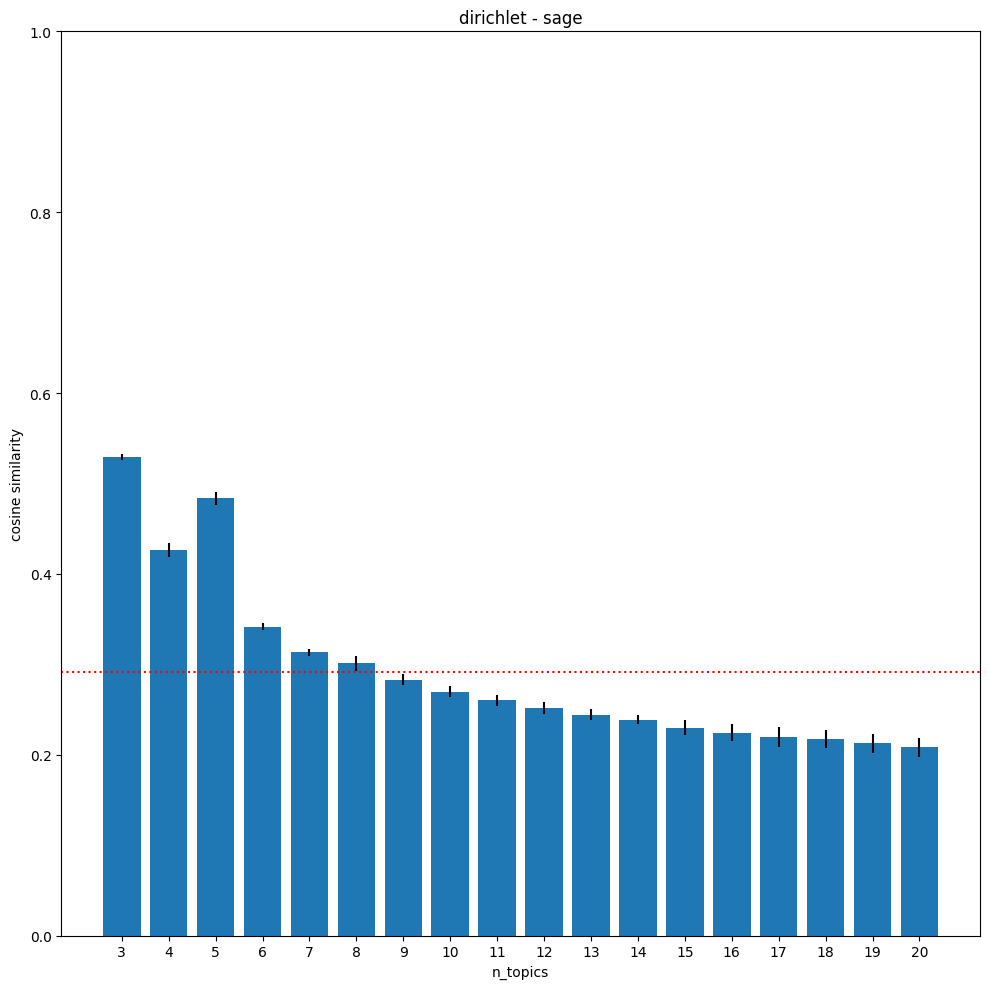

In [5]:
fig = plt.figure(figsize=(10,10),facecolor="white", tight_layout=True)
ax = fig.add_subplot(1, 1, 1,xlabel="n_topics", ylabel="cosine similarity")
df_score_res = pd.DataFrame(cossim_list,index=["Topic{}".format(i) for i in range(3,21)])
x = np.array(range(3,21))
mean = df_score_res.mean(axis=1)
std = df_score_res.std(axis=1)
ax.bar(x, mean, yerr=std)
ax.axhline(mean.mean(), color='r', linestyle='dotted')
ax.set_ylim(0, 1)
ax.set_xticks(range(3,21))
ax.set_title("{} - {}".format(gtm_model_args["doc_topic_prior"],gtm_model_args["decoder_type"]))
# plt.savefig("../fig/{}_{}_{}_{}.png".format(model_type,score_type,gtm_model_args["doc_topic_prior"],gtm_model_args["decoder_type"]))
plt.subplots_adjust(hspace=0.4)
plt.show()

#### plot the mean training loss per n_topics

In [8]:
df_loss

,0,1,2,3,4,5,6,7,8,9
0,11.043720,6.336796,4.780350,4.465163,4.344967,4.028218,3.933621,3.718228,3.550101,3.402130
1,12.338957,9.262536,6.942206,6.253352,5.654739,5.065634,4.678353,4.362012,4.065519,3.819487
2,11.358131,4.432047,3.697855,3.481700,3.435804,3.334278,3.241379,3.263502,3.197034,3.150337
3,13.261681,11.039212,7.730408,6.578801,5.765715,5.245544,4.675017,4.350989,4.045939,3.794288
4,13.511070,10.878322,7.855905,6.684198,5.854157,5.199515,4.754283,4.350883,4.031094,3.768372
5,13.308302,9.669125,7.919799,7.026537,6.211778,5.493650,4.938731,4.488938,4.083488,3.858922
6,13.648358,10.155221,7.924928,6.938764,6.044958,5.364534,4.811269,4.363092,4.008738,3.777304
7,13.481588,9.709578,8.011361,7.039717,6.218141,5.428992,4.840224,4.387333,3.979664,3.709380
8,13.616817,9.830201,8.086797,7.081090,6.282461,5.489353,4.863410,4.344775,3.982187,3.723822
9,13.239900,9.555710,8.186941,7.296045,6.410573,5.606893,4.930479,4.393947,4.029196,3.723115


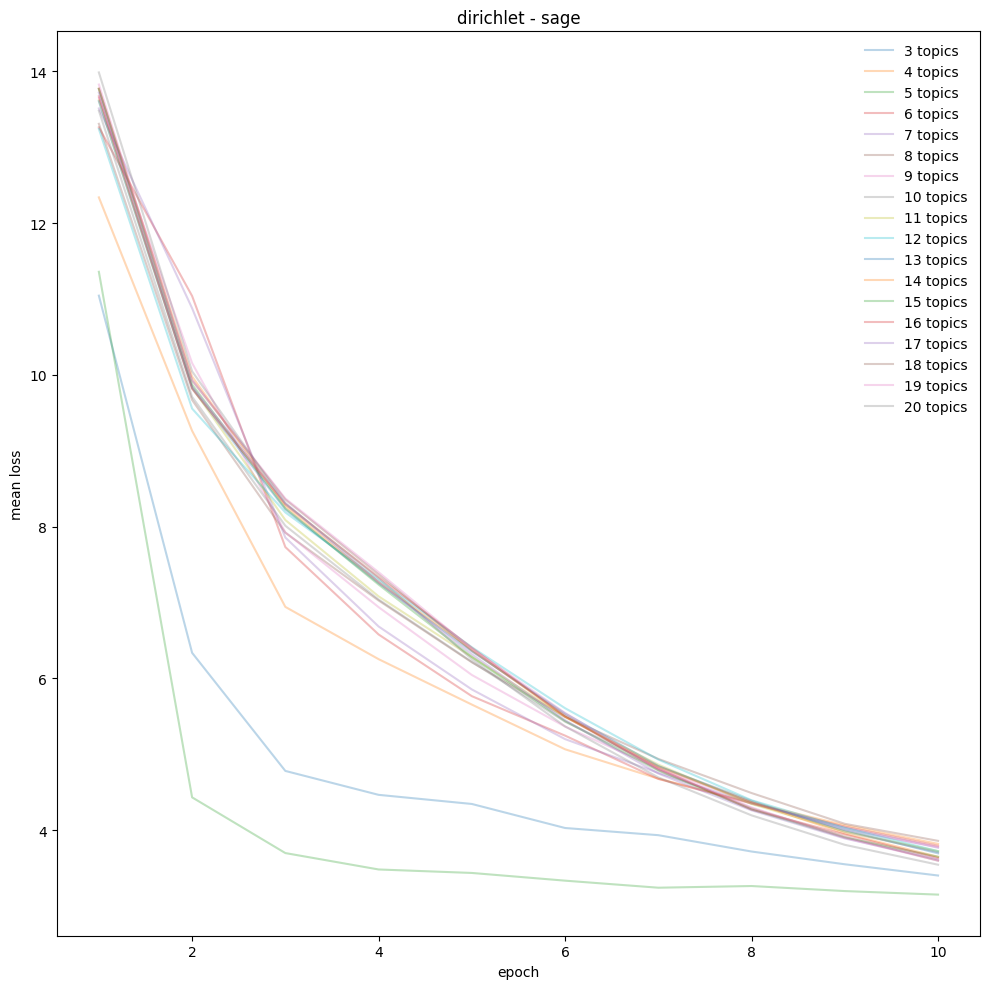

In [10]:
fig = plt.figure(figsize=(10,10),facecolor="white", tight_layout=True)
ax = fig.add_subplot(1, 1, 1,xlabel="epoch", ylabel="mean loss")
df_loss = pd.DataFrame(mean_train_loss_list)
x = np.array([i+1 for i in range(df_loss.shape[1])])

for i in range(df_loss.shape[0]):
    ax.plot(x, df_loss.iloc[i,:],label="{} topics".format(i+3), alpha=0.3)



ax.set_title("{} - {}".format(gtm_model_args["doc_topic_prior"],gtm_model_args["decoder_type"]))
# plt.savefig("../fig/{}_{}_{}_{}.png".format(model_type,score_type,gtm_model_args["doc_topic_prior"],gtm_model_args["decoder_type"]))
plt.legend(framealpha=0)
plt.subplots_adjust(hspace=0.4)
plt.show()